# Определение перспективного тарифа для телеком-компании

Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание тарифов

**Тариф «Смарт»**

* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 3 рубля
  * сообщение: 3 рубля
  * 1 Гб интернет-трафика: 200 рублей
  
  

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
  * минута разговора: 1 рубль
  * сообщение: 1 рубль
  * 1 Гб интернет-трафика: 150 рублей

**Примечание**

«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.


## Открытие файла

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import plotly.express as ex
import matplotlib.pyplot as plt
import plotly as pl
import numpy as np
import plotly.graph_objs as go

Выведем общую информацию и все таблицы на экран для ознакомления.

In [2]:
calls = pd.read_csv('calls.csv')
internet = pd.read_csv('internet.csv', index_col=0)
messages = pd.read_csv('messages.csv')
tariffs = pd.read_csv('tariffs.csv')
users = pd.read_csv('users.csv')

display (calls)
#display (calls, internet, messages, tariffs, users)
#calls.info()
#internet.info()
messages.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


У нас есть 5 таблиц, 3 из которых содержат данные о звонках, сообщениях и интернет трафике, который потратили пользователи. Эти 3 таблицы объединяет столбец с идентификатором пользователя, который так же объединяет их с таблицей о самих пользователях `users`. Таблица с тарифами содержит тарифный план и объединяется с таблице `users` через наименование тарифа в столбце `tariff`.

Объединим таблицы внешним типом слияния, чтобы сохранить все записи

In [3]:
df = calls.merge(internet, how='outer')
df = df.merge(messages, how='outer')
df = df.merge(users, how='outer')
df.head(10)

,id,call_date,duration,user_id,mb_used,session_date,message_date,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000_0,2018-07-25,0.00,1000,112.95,2018-11-25,2018-06-27,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000_1,2018-08-17,0.00,1000,1052.81,2018-09-07,2018-10-08,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000_2,2018-06-11,2.85,1000,1197.26,2018-06-25,2018-08-04,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000_3,2018-09-21,13.80,1000,550.27,2018-08-22,2018-06-16,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000_4,2018-12-15,5.18,1000,302.56,2018-09-24,2018-12-05,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
5,1000_5,2018-11-02,0.00,1000,399.97,2018-10-02,2018-06-20,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
6,1000_6,2018-10-18,0.00,1000,540.08,2018-09-07,2018-11-19,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
7,1000_7,2018-08-22,18.31,1000,415.70,2018-07-11,2018-10-29,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
8,1000_8,2018-09-15,18.44,1000,505.40,2018-10-08,2018-06-25,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
9,1000_9,2018-08-15,0.00,1000,345.54,2018-09-03,2018-12-18,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


Удалим столбцы, которые нам не пригодятся для проведения анализа и объединим имя и фамилию клиента

In [4]:
df['name'] = df['first_name'] + [' '] + df['last_name']
df.drop(labels=['id', 'first_name', 'last_name' ], axis=1, inplace=True,)

## Подготовка данных

### Замена типа данных

Чтобы заменить столбцы с датами на соответсвующий тип данных создадим функцию для преобразования столбцов.

In [5]:
df.head()

,call_date,duration,user_id,mb_used,session_date,message_date,age,churn_date,city,reg_date,tariff,name
0,2018-07-25,0.00,1000,112.95,2018-11-25,2018-06-27,52,NaN,Краснодар,2018-05-25,ultra,Рафаил Верещагин
1,2018-08-17,0.00,1000,1052.81,2018-09-07,2018-10-08,52,NaN,Краснодар,2018-05-25,ultra,Рафаил Верещагин
2,2018-06-11,2.85,1000,1197.26,2018-06-25,2018-08-04,52,NaN,Краснодар,2018-05-25,ultra,Рафаил Верещагин
3,2018-09-21,13.80,1000,550.27,2018-08-22,2018-06-16,52,NaN,Краснодар,2018-05-25,ultra,Рафаил Верещагин
4,2018-12-15,5.18,1000,302.56,2018-09-24,2018-12-05,52,NaN,Краснодар,2018-05-25,ultra,Рафаил Верещагин


In [6]:
time_columns = ['call_date', 'session_date', 'message_date', 'churn_date', 'reg_date']
for column in time_columns:
    df[column] = pd.to_datetime(df[column], format = '%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237281 entries, 0 to 237280
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   call_date     202607 non-null  datetime64[ns]
 1   duration      202607 non-null  float64       
 2   user_id       237281 non-null  int64         
 3   mb_used       149396 non-null  float64       
 4   session_date  149396 non-null  datetime64[ns]
 5   message_date  123036 non-null  datetime64[ns]
 6   age           237281 non-null  int64         
 7   churn_date    11187 non-null   datetime64[ns]
 8   city          237281 non-null  object        
 9   reg_date      237281 non-null  datetime64[ns]
 10  tariff        237281 non-null  object        
 11  name          237281 non-null  object        
dtypes: datetime64[ns](5), float64(2), int64(2), object(3)
memory usage: 23.5+ MB


### Подсчет данных для каждого пользователя

Чтобы посчитать ежемесячную выручку по каждому пользователю, сначала сгруппируем данные по пользователям и месяцам, добавим информацию о тарифах и посчитаем необходимые величины.

In [7]:
# добавление столбцов с звонками, сообщениями и интернет-сессиями по месяцам 
df['call_month'] = df['call_date'].astype('datetime64[M]')
df['message_month'] = df['message_date'].astype('datetime64[M]')
df['session_month'] = df['session_date'].astype('datetime64[M]')
# df['session_month'] = pd.DatetimeIndex(df['session_date']).month.astype('Int64')

In [8]:
# сводная таблица количество сделанных звонков и израсходованных минут разговора по месяцам
calls = df.pivot_table(index=['user_id', 'call_month'], values='duration', aggfunc=('count', 'sum')).reset_index()
calls.columns=['user_id', 'month', 'call_count', 'total_duration']

# сводная таблица количество отправленных сообщений по месяцам
messages = df.pivot_table(index=['user_id', 'message_month'], values='message_date', aggfunc='count').reset_index()
messages.columns=['user_id', 'month', 'message_count']

# сводная таблица объем израсходованного интернет-трафика по месяцам
sessions = df.pivot_table(index=['user_id', 'session_month'], values='mb_used', aggfunc='sum').reset_index()
sessions.columns=['user_id', 'month', 'mb_used_total']

In [9]:
# объединение таблиц
df_users = calls.merge(messages,  on=['user_id', 'month'], how='outer')
df_users = df_users.merge(sessions,  on=['user_id', 'month'], how='outer')
df_users.head()

,user_id,month,call_count,total_duration,message_count,mb_used_total
0,1000,2018-05-01,22.0,150.06,22.0,2253.49
1,1000,2018-06-01,43.0,158.90,60.0,23233.77
2,1000,2018-07-01,47.0,318.80,75.0,14003.64
3,1000,2018-08-01,52.0,389.87,81.0,14055.93
4,1000,2018-09-01,58.0,440.14,57.0,14568.91


«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.

In [10]:
# округление секунд до минут
df_users['total_duration'] = np.ceil(df_users['total_duration'])
df_users.head()

,user_id,month,call_count,total_duration,message_count,mb_used_total
0,1000,2018-05-01,22.0,151.0,22.0,2253.49
1,1000,2018-06-01,43.0,159.0,60.0,23233.77
2,1000,2018-07-01,47.0,319.0,75.0,14003.64
3,1000,2018-08-01,52.0,390.0,81.0,14055.93
4,1000,2018-09-01,58.0,441.0,57.0,14568.91


Также добавим в таблицу названия тарифов, которыми пользуются клиенты.

In [11]:
# добавление столбцов с названием тарифа
users_tariff = users[['user_id', 'tariff']]
df_users = df_users.merge(users_tariff, on='user_id', how = 'left')

# переимуем название колонки tariffs
tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)

# объединение с таблицей по тарифам
df_users = df_users.merge(tariffs, on='tariff')
df_users.head()

,user_id,month,call_count,total_duration,message_count,mb_used_total,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,2018-05-01,22.0,151.0,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1
1,1000,2018-06-01,43.0,159.0,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1
2,1000,2018-07-01,47.0,319.0,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1
3,1000,2018-08-01,52.0,390.0,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1
4,1000,2018-09-01,58.0,441.0,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1


Добавим в таблицу столбец с количеством использованных гигобайт с округлением в большую сторону и количество гигобайт, включенных в тариф.

In [12]:
df_users['gb_used_total'] = (df_users['mb_used_total'] / 1024)
df_users['gb_used_total'] = np.ceil(df_users['gb_used_total'])
df_users['gb_per_month_included'] = (df_users['mb_per_month_included'] / 1024)
df_users['gb_per_month_included'] = np.ceil(df_users['gb_per_month_included'])
df_users.reset_index()
df_users.head()

,user_id,month,call_count,total_duration,message_count,mb_used_total,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used_total,gb_per_month_included
0,1000,2018-05-01,22.0,151.0,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1,3.0,30.0
1,1000,2018-06-01,43.0,159.0,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1,23.0,30.0
2,1000,2018-07-01,47.0,319.0,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1,14.0,30.0
3,1000,2018-08-01,52.0,390.0,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1,14.0,30.0
4,1000,2018-09-01,58.0,441.0,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1,15.0,30.0


Теперь необходимо посчитать помесячную выручку с каждого пользователя, для этого вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножим на значение из тарифного плана; прибавим абонентскую плату, соответствующую тарифному плану

In [13]:
# посчитаем выручку с каждого пользователя за минуты, смс и интернет
mins = (df_users['total_duration'] - df_users['minutes_included']) * df_users['rub_per_minute']
sms = (df_users['message_count'] - df_users['messages_included']) * df_users['rub_per_message']
gb = (df_users['gb_used_total'] - df_users['gb_per_month_included']) * df_users['rub_per_gb']

# если пользователь укладывался в тариф, доплаты у него не происходили
mins = np.clip(mins, 0, None)
sms.loc[sms < 0] = 0
gb.loc[gb < 0] = 0

# сложим выручку и прибавим абонентскую плату
df_users['revenue'] = mins + sms + gb + df_users['rub_monthly_fee']
df_users.head()

,user_id,month,call_count,total_duration,message_count,mb_used_total,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,gb_used_total,gb_per_month_included,revenue
0,1000,2018-05-01,22.0,151.0,22.0,2253.49,ultra,1000,30720,3000,1950,150,1,1,3.0,30.0,1950.0
1,1000,2018-06-01,43.0,159.0,60.0,23233.77,ultra,1000,30720,3000,1950,150,1,1,23.0,30.0,1950.0
2,1000,2018-07-01,47.0,319.0,75.0,14003.64,ultra,1000,30720,3000,1950,150,1,1,14.0,30.0,1950.0
3,1000,2018-08-01,52.0,390.0,81.0,14055.93,ultra,1000,30720,3000,1950,150,1,1,14.0,30.0,1950.0
4,1000,2018-09-01,58.0,441.0,57.0,14568.91,ultra,1000,30720,3000,1950,150,1,1,15.0,30.0,1950.0


## Анализ данных

Необходимо описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитать среднее количество, дисперсию и стандартное отклонение. Построить гистограммы. Описать распределения.

Звонки в месяц


,mean,var,std,median
,total_duration,total_duration,total_duration,total_duration
tariff,,,,
smart,395.985155,32058.431373,179.048684,399.0
ultra,515.331230,84000.788066,289.828894,498.0


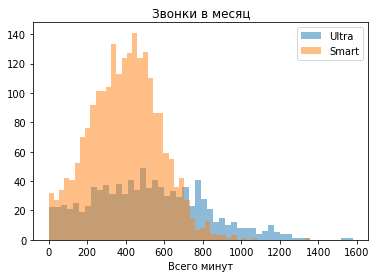

СМС в месяц


,mean,var,std,median
,message_count,message_count,message_count,message_count
tariff,,,,
smart,38.716441,717.594201,26.787949,34.0
ultra,61.161006,2109.659183,45.931026,51.0


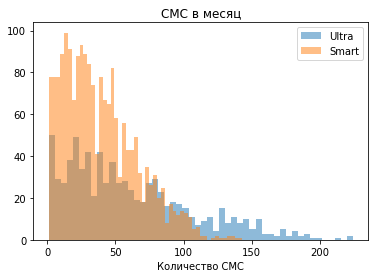

Интернет-трафик в месяц


,mean,var,std,median
,gb_used_total,gb_used_total,gb_used_total,gb_used_total
tariff,,,,
smart,16.336176,32.923756,5.737923,17.0
ultra,19.694359,94.146734,9.702924,19.0


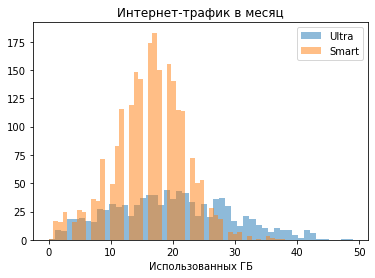

In [14]:
columns = ['total_duration', 'message_count', 'gb_used_total']
names = ['Звонки в месяц', 'СМС в месяц', 'Интернет-трафик в месяц']
xlabel = ['Всего минут', 'Количество СМС', 'Использованных ГБ']

for column in range(len(columns)):
    
    # создадим переменные для двух тарифов
    ultra = df_users[df_users['tariff'] == 'ultra']
    smart = df_users[df_users['tariff'] == 'smart']
    
    # создадим гистограмму для двух тарифов в месяц
    plt.hist(ultra[columns[column]], bins=50, alpha=0.5, label='Ultra')
    plt.hist(smart[columns[column]], bins=50, alpha=0.5, label='Smart')
    
    # посчитаем среднее, дисперсию и стандартное отклонение
    print (names[column])
    
    df_pivot = df_users.pivot_table(index= 'tariff', values= columns[column],  aggfunc= ['mean', 'var','std', 'median'])
    display (df_pivot)
    
    # выведем на экран
    plt.title(names[column])
    plt.xlabel(xlabel[column])
    plt.legend()
    plt.show()


**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля, сообщение: 3 рубля
* 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль, сообщение: 1 рубль
* 1 Гб интернет-трафика: 150 рублей

Звонки:
* Несмотря на 3000 минут включенных в тариф Ultra, среднее количество минут в месяц у всех пользователей не превышает 1600.
* В среднем пользователи Smart тратят около 400 минут в месяц, а пользователи Ultra - около 500 минут.
* Пользователям тарифа Ultra не требуется 3000 включенных в абонентскую плату минут, такое количество просто не используется, его можно снизить до 1000 минут

СМС:
* В среднем пользователи Smart отправляют около 40 сообщений в месяц, а пользователи Ultra - около 60 сообщений.
* Включенные в абонентскую плату 1000 сообщений не используются совсем, так как в месяц пользователи отправляют не более 250 сообщений в среднем в обоих тарифах.

Трафик:
* В тарифе Smart среднее количество использованных ГБ в месяц - 16.3, а в тариф включено всего 15 гб, соответственно переплата за тариф у пользователей составляет минимум 200 рублей.
* Пользователи тарифа Ultra используют до 50 гб в месяц.

Несмотря на то, что в тарифе Ultra включено 3000 минут разговора и 1000 сообщений - такое количество не используется, пользователям достаточно до 1000 минут и до 200 сообщений в месяц. С интернет-трафиком - наоборот: пользователи переплачивают за гб, которых в тарифе недостаточно, из-за чего тариф Smart получается минимум на 200 р дороже.


## Проверка гипотез

* Нулевая гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая
* Альтернативная гипотеза: Средняя выручка пользователей тарифов «Ультра» и «Смарт» разная

In [15]:
from scipy import stats as st

ultra = df_users[df_users['tariff'] == 'ultra']['revenue'].dropna()
smart = df_users[df_users['tariff'] == 'smart']['revenue'].dropna()
print ('Дисперсия Ultra', ultra.var(), 'Дисперсия Smart', smart.var())
print ('Средняя выручка Ultra', ultra.mean(), 'Средняя выручка Smart', smart.mean())

alpha = 0.05

results = st.ttest_ind(ultra, smart, equal_var=False)

print('p-значение:', results.pvalue) # ваш код: выведите на экран получившееся p-значение)

if results.pvalue < alpha: # ваш код: сравните получившееся p-значение с заданным уровнем статистической значимости :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия Ultra 110817.77488171868 Дисперсия Smart 648186.9392231536
Средняя выручка Ultra 2048.936170212766 Средняя выручка Smart 1257.9472584856396
p-значение: 2.4562350563259974e-230
Отвергаем нулевую гипотезу


**Гипотеза о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различна подтвердилась.**

* Нулевая гипотеза: Средняя выручка пользователей из Москвы и выручка пользователей из других регионов одинаковая
* Альтернативная гипотеза: Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [16]:
df_users = df_users.merge(users)

moscow = df_users[df_users['city'] == 'Москва']['revenue'].dropna()
other = df_users[df_users['city'] != 'Москва']['revenue'].dropna()
print ('Дисперсия пользователей из Москвы', moscow.var(), 'Дисперсия пользователей из других регионов', smart.var())

alpha = 0.05

results = st.ttest_ind(moscow, other)

print('p-значение:', results.pvalue) # ваш код: выведите на экран получившееся p-значение)

if results.pvalue < alpha: # ваш код: сравните получившееся p-значение с заданным уровнем статистической значимости :
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

Дисперсия пользователей из Москвы 584439.0360364106 Дисперсия пользователей из других регионов 648186.9392231536
p-значение: 0.08244090114571569
Не получилось отвергнуть нулевую гипотезу


**Гипотеза о том, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов не подтвердилась.**

## Вывод

1. Несмотря на то, что в тарифе Ultra включено 3000 минут разговора и 1000 сообщений - такое количество не используется, пользователям достаточно до 1000 минут и до 200 сообщений в месяц. С интернет-трафиком - наоборот: пользователи переплачивают за гб, которых в тарифе недостаточно, из-за чего тариф Smart получается минимум на 200 р дороже.

2. Средняя выручка пользователей тарифа Ultra выше, чем выручка с тарифа Smart.

3. Средняя выручка пользователей из Москвы и выручка пользователей из других регионов примерно одинаковая.

Портрет пользователя тарифа Ultra:
* Несмотря на 3000 минут включенных в тариф Ultra, среднее количество минут в месяц у пользователя не превышает 1600.
* В среднем пользователь Ultra тратит около 500 минут в месяц.
* Пользователь Ultra отправляет около 60 сообщений.
* Пользователь тарифа Ultra используют до 50 гб в месяц.
 
 Пользователям тарифа Ultra не требуется 3000 включенных в абонентскую плату минут, такое количество просто не используется, его можно снизить до 1000 минут. Включенные в абонентскую плату 1000 сообщений не используются совсем, так как в месяц пользователи отправляют не более 250 сообщений.
 
Портрет пользователя тарифа Smart:
* Пользователь Smart тратит около 400 минут в месяц.
* В среднем пользователь Smart отправляет около 40 сообщений в месяц.
* В тарифе Smart среднее количество использованных ГБ в месяц - 16.3.

В тариф включено всего 15 гб, соответственно переплата за тариф у пользователей составляет минимум 200 рублей.

Исходя из результатов исследования можно сделать вывод, что пользователи в основном используют интернет, а не звонки и СМС, но довольно много переплачивают за неиспользованные минуты и смс, в обоих тарифах количество минут можно снизить до 1000 в тарифе Ultra и до 500 в тарифе Smart. Также количество СМС можно снизить до 100 в обоих тарифах. А вот за гигобайты пользователи готовы доплачивать, поэтому их количество можно повышать.